In [18]:
import random
import pandas as pd
random.seed(671)

# p = 0.03
# def my_row_sampling_function(i):
#     return i>0 and random.random() > p
# df = pd.read_csv('user_game/user_game_time.csv', skiprows=my_row_sampling_function,index_col=0)

# df.to_csv('sampled_time.csv', index=False)

df = pd.read_csv('user_game/sampled_time.csv')

df.head()

,uid,gid,playtime
0,76561197970982479,47700,85
1,76561197970982479,31230,0
2,76561197970982479,21970,64
3,76561197970982479,18500,126
4,76561197970982479,294860,1735


# EDA

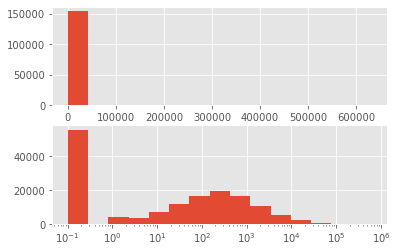

In [19]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style

def plot_dist(df, col):
    style.use('ggplot')

    x = df[col]+0.1

    plt.subplot(211)
    hist, bins, _ = plt.hist(x, bins=15)

    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.subplot(212)
    plt.hist(x, bins=logbins)
    plt.xscale('log')
    plt.show()

plot_dist(df, 'playtime')

## Preprocessing

In [20]:
def NormalizeData(data): # map to [0,10]
    return (data - np.min(data)) * 10 / (np.max(data) - np.min(data))
    
def rescale(data):
    return NormalizeData(np.log10(data+0.1))

df['playtime_rescale'] = rescale(df['playtime'])
utime = df

In [21]:
x = utime['playtime_rescale']
(x.max(), x.min())

(10.0, 0.0)

In [22]:
!pip install surprise
from surprise import Reader, Dataset
from surprise import SVD, SVDpp, NMF, KNNWithMeans
from surprise.model_selection import GridSearchCV

results = []

def run(data, algo, algo_name, params, n=2): # Perform cross validation
    gs = GridSearchCV(algo, params, measures=['MAE'], n_jobs=8, cv=n) # perform grid search on parameters
    gs.fit(data) # fit data
    df = pd.DataFrame({'algo': algo_name, 'mae': gs.best_score}) # get best value with the cross validation
    results.append(df)
    return df, gs.best_params, gs.best_estimator

In [23]:
reader = Reader(rating_scale=(x.min(), x.max())) # a reader of rating [1,10]
data = Dataset.load_from_df(utime[['gid', 'uid', 'playtime_rescale']], reader) # mind the order of columns

In [24]:
df, param, model = run(data, SVD, 'SVD', {
    'random_state': [671],
    'n_epochs': [25], 
    'lr_all': [0.007, 0.01],
}, 5) # gs svd

In [9]:
df, param

(    algo       mae
 mae  SVD  1.634581,
 {'mae': {'random_state': 671, 'n_epochs': 25, 'lr_all': 0.007}})

In [10]:
import pickle
model = SVD(random_state=671, n_epochs=25, lr_all=0.07)
model.fit(data.build_full_trainset())
pickle.dump( model, open( "utime_svd.pkl", "wb" ) )

In [33]:
# usage
model = pickle.load(open( "utime_svd.pkl", "rb" ) )
model.predict('35420', 'js41637').est

2.7856232152532505

In [34]:
model.predict('250320', 'doctr').est

3.3525081101237455

# Recommend

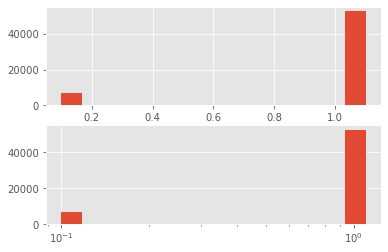

In [12]:
rec = pd.read_csv('user_game/user_game_recommend.csv',index_col=0)
plot_dist(rec, 'recommend')

In [13]:
rec['rec_rescale'] = rescale(rec['recommend'])
x = rec['rec_rescale']
reader = Reader(rating_scale=(x.min(), x.max())) # a reader of rating [0,10]
rec_data = Dataset.load_from_df(rec[['gid', 'uid', 'rec_rescale']], reader) # mind the order of columns

In [14]:
df, param, model = run(rec_data, SVD, 'SVD', {
    'random_state': [671],
    'n_epochs': [25], 
    'lr_all': [0.07, 0.01],
}, 5) # gs svd

In [15]:
df, param

(    algo       mae
 mae  SVD  1.719553,
 {'mae': {'random_state': 671, 'n_epochs': 25, 'lr_all': 0.01}})

In [33]:
model = SVD(random_state=671, n_epochs=25, lr_all=0.01)
model.fit(rec_data.build_full_trainset())
pickle.dump( model, open( "urecommend_svd.pkl", "wb" ) )

In [32]:
# usage
model = pickle.load(open( "urecommend_svd.pkl", "rb" ))
model.predict('250320', 'doctr').est

9.220844178859826

In [35]:
rec

,uid,gid,recommend,rec_rescale
0,76561197970982479,1250,1,10.0
1,76561197970982479,22200,1,10.0
2,76561197970982479,43110,1,10.0
3,js41637,251610,1,10.0
4,js41637,227300,1,10.0
...,...,...,...,...
59300,76561198312638244,70,1,10.0
59301,76561198312638244,362890,1,10.0
59302,LydiaMorley,273110,1,10.0
59303,LydiaMorley,730,1,10.0
